# R0 Covid Analysis
##### Giampaolo Martiniello giampaolo.martiniello@mail.polimi.it 


### The simplest model

Let's consider the spread of a virus in a population: what interests us is the spread of the epidemic, and to do this we divide the population into "compartments".
In the simplest model we have two compartments:

$S$ :(which stands for Susceptible) that is the group of people who do not have the disease but can contract it.

$I$ : (which stands for Infected) that is the group of people who have contracted the disease.

What we want to understand is the passage $S\to I$, which involves figuring out how many susceptible become infected, and at what speed. In this model we therefore assume that a susceptible can become infected and, once infected, remain in the compartment $I$.

We will assume that the total number of people in the population is $N$
and remains constant, while obviously we assume that $S$ and $I$ vary over time, so at every instant $t$ we have that $S(t)+I(t)=N$. What we want to determine  if $\Delta I(t) = I(t+\Delta t) - I(t)$  is the increase in people who contract the infection between the instant $t$ and the instant $t+\Delta t$ .
The hypothesis we make is that this increase satisfies the relationship of proportionality :
$$ \Delta I(t) = \beta \frac{I(t)S(t)}{N}\,\Delta t $$
where $\beta>0$ is a constant that denotes how much the infected grow over the time interval $\Delta t$, precisely the rate of contacts in the population. Assuming that our variables are continuous (even if in reality they are discrete as they represent the size of a population), we are therefore tempted to deduce that
$$ \frac{\Delta I(t)}{\Delta t} = \beta \frac{I(t)S(t)}{N} $$

 ### The SIR model

However, it is reasonable to assume that the number of infected decreases not only because some of them return to the susceptible, but also for other reasons: in general this happens for all epidemics. The infected can heal and develop immunity, so they are no longer likely to contract the disease, or die, or be isolated.
It is therefore natural to modify our model by introducing a new compartment, $R$ (which stands for removed) and contains the infected that are no longer infected but not even more susceptible. The scheme of this $SIR$ model contemplates that you can pass into compartment $R$ only if you come from compartment $I$ :

$S → I → R$

(This type of model was proposed by Kermack and McKendrick in a series of classic works between 1927 and 1933.).
Basically it is a question of adding an equation for the dynamics of the passage $I → R$, which leads to expand the equations of the $SI$ model as follows:
    \begin{cases}
\displaystyle
    S' = -\beta\frac{IS}{N}   \\
\displaystyle
    I' = \beta \frac{IS}{N} -\gamma I  \\
\displaystyle
    R' = \gamma I
\end{cases}

We note that this time $N=S+I+R$ and that, adding the three differential equations, we find $S′+I′+R′=0$, therefore $N$ constant again .
It turns out that also in this case what governs is the constant $\sigma = \beta/\gamma$.


$β$ : is the contact rate, and we assume that in a unit time each infected individual will come into contact with $βN$ people. From those people, the proportion of susceptible people is $S/N$, thus the speed at which new infections occur is defined as $-\frac{βSI}{N}$.
    
$γ$ :is the recovery rate, and the number $1/γ$ defines the number of days during which a person stays infected. Thus the term $γI$ defines the speed, at which infected individuals are moved from being infected to recovered.
 
The $σ$ in the $SIR$ model corresponds to the famous coefficient $R0$ of which estimates are occasionally read and to which great importance is attributed, justified by the critical threshold theorem.

I will use the $SIR$ model, which means that we have to take the data of an epidemic and in particular, for each instant, the total of susceptible, infected and removed.

### What is R0 ?

$R0$, pronounced “R naught,” is a mathematical term that indicates how contagious an infectious disease is. It’s also referred to as the reproduction number. As an infection is transmitted to new people, it reproduces itself.
$R0$ tells us the average number of people who will contract a contagious disease from one person with that disease. It specifically applies to a population of people who were previously free of infection and haven’t been vaccinated.

#### What do R0 values mean?
Three possibilities exist for the potential transmission or decline of a disease, depending on its $R0$ value:

    
If $R0$ is less than 1, each existing infection causes less than one new infection. In this case, the disease will decline and eventually die out.
    
If $R0$ equals 1, each existing infection causes one new infection. The disease will stay alive and stable, but there won’t be an outbreak or an epidemic.

If $R0$ is more than 1, each existing infection causes more than one new infection. The disease will be transmitted between people, and there may be an outbreak or epidemic.

### Dataset used for the project

For this project the github repository of the The Civil Protection Department: https://github.com/pcm-dpc/COVID-19 is used .

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import dates
from scipy.optimize import fmin
from scipy.integrate import odeint
from datetime import datetime


In [2]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
dfr = pd.read_csv(url,error_bad_lines=False)
dfr['data'] = pd.to_datetime(dfr['data'])
dfr['Days'] = (dfr.data.diff().dt.days+dfr.data.diff().dt.seconds/86400).cumsum().fillna(0).round(0)

C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
dfr.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,Days
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,0,221,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,93,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,78,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,250,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,238,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0


In [4]:
print('Ultimo aggiornamento', datetime.today().date())

Ultimo aggiornamento 2022-02-08


In [5]:
dfr['NuoviCasi Totali'] = dfr['totale_casi'].diff()
dfr1 = dfr[['data','terapia_intensiva','totale_positivi','totale_casi','deceduti','Days','NuoviCasi Totali','dimessi_guariti','tamponi']]
dfr1.tail(10)

,data,terapia_intensiva,totale_positivi,totale_casi,deceduti,Days,NuoviCasi Totali,dimessi_guariti,tamponi
706,2022-01-30 17:00:00,1593,2643817,10925485,146149,706.0,104110.0,8135519,170153413
707,2022-01-31 17:00:00,1584,2592606,10983116,146498,707.0,57631.0,8244012,170631727
708,2022-02-01 17:00:00,1549,2476514,11116422,146925,708.0,133306.0,8492983,171878714
709,2022-02-02 17:00:00,1524,2407626,11235745,147320,709.0,119323.0,8680799,172843235
710,2022-02-03 17:00:00,1457,2328230,11348701,147734,710.0,112956.0,8872737,173758572
711,2022-02-04 17:00:00,1440,2218344,11449601,148167,711.0,100900.0,9083090,174643465
712,2022-02-05 17:00:00,1411,2128543,11542793,148542,712.0,93192.0,9265708,175489945
713,2022-02-06 17:00:00,1431,2073248,11621736,148771,713.0,78943.0,9399717,176176489
714,2022-02-07 17:00:00,1423,1990701,11663338,149097,714.0,41602.0,9523540,176570152
715,2022-02-08 17:00:00,1376,1927800,11765767,149512,715.0,102429.0,9688455,177569247


At this point we want to consider only the first 2 months of the pandemic also to see the incidence and diffusion of the first wave for this reason we exclude, at least for the moment, subsequent measurements.

In [6]:
# create dataset with the first 60 days
dfr2 =dfr1.head(60)
dfr2

,data,terapia_intensiva,totale_positivi,totale_casi,deceduti,Days,NuoviCasi Totali,dimessi_guariti,tamponi
0,2020-02-24 18:00:00,26,221,229,7,0.0,NaN,1,4324
1,2020-02-25 18:00:00,35,311,322,10,1.0,93.0,1,8623
2,2020-02-26 18:00:00,36,385,400,12,2.0,78.0,3,9587
3,2020-02-27 18:00:00,56,588,650,17,3.0,250.0,45,12014
4,2020-02-28 18:00:00,64,821,888,21,4.0,238.0,46,15695
5,2020-02-29 18:00:00,105,1049,1128,29,5.0,240.0,50,18661
6,2020-03-01 18:00:00,140,1577,1694,34,6.0,566.0,83,21127
7,2020-03-02 18:00:00,166,1835,2036,52,7.0,342.0,149,23345
8,2020-03-03 18:00:00,229,2263,2502,79,8.0,466.0,160,25856
9,2020-03-04 18:00:00,295,2706,3089,107,9.0,587.0,276,29837


For my purposes , the data used are the values of $I$ and $R$, which I can extract as :
1. $I(t)$  is given by the value of the "totale_positivi".
2. $R(t)$  is given by the sum of the values of the fields "dimessi_guariti" and "deceduti"
3. $N$     is given by the value of the "tamponi"

Compared to our models, we note that the $N$ value is anything but constant: a way to overcome this problem is to take the most recent (and therefore highest) value and use it as $N$ .As a first approach we use the mean of $N$ 

###  The SIR model applied 

Let's try this first solution.
The main functions we use in this first step are:

1. *def SIR* : The following function returns an array with the S, I and R curves calculated at the points of the interval, starting from the historical series and on optimized beta and gamma
2. *def calculated_R0* : Solve the system of equations $S'=..., I'=..., R'=...$
3. *fmin* :Find the optimal beta and gamma value

beta ottimale = 0.20123529585081604
gamma ottimale = 0.06814624336632574
R0 ottimale = 2.9529917704936297


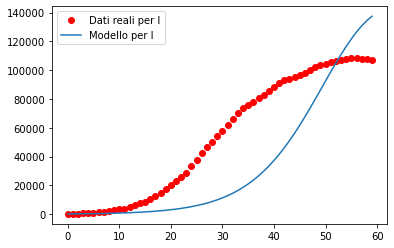

In [7]:
# The following function returns an array with the S, I and R curves calculated at the points
# of the interval, starting from the historical series and on optimized beta and gamma 
def SIR(N0, serie_I, serie_R, intervallo, verbose=True):
    serie_S = N0 - serie_I - serie_R
    serie_SIR = np.array([[serie_S[i], serie_I[i], serie_R[i]] for i in range(len(serie_I))])
    SIR0 = serie_SIR[0]

    # We calibrate for t0 = 0, t1 = series length - 1
    intervallo_dati = np.arange(len(serie_I))

    def fun_SIR(y, t, beta, gamma):
        # y = [S(t), I(t), R(t)]
        return [-beta*y[0]*y[1]/N0,
                beta*y[0]*y[1]/N0-gamma*y[1],
                gamma*y[1] ]

    def calculated_R0(parametri):
        # Solve the system of equations $ S '= ..., I' = ..., R '= ... $
        y = odeint(fun_SIR, SIR0, intervallo_dati, args=tuple(parametri))
        return np.linalg.norm(y - serie_SIR)
    
# Find the optimal beta and gamma value
    valori_ottimali = fmin(calculated_R0, (1,1), disp = False)   # initial values of beta and gamma = 1

    if verbose:
        print("beta ottimale =", valori_ottimali[0])
        print("gamma ottimale =", valori_ottimali[1])
        print("R0 ottimale =", valori_ottimali[0]/valori_ottimali[1])

    return odeint(fun_SIR, SIR0, intervallo, args=(valori_ottimali[0],valori_ottimali[1]))

# N0 on mean of number of tamponi
N0 = np.mean(dfr2["tamponi"])

serie_I = np.array(dfr2["totale_positivi"])
serie_R = np.array(dfr2["dimessi_guariti"] + dfr2["deceduti"])

# Now plot the solution for the optimal values
intervallo = np.arange(len(serie_I))
y = SIR(N0, serie_I, serie_R, intervallo)
plt.plot(intervallo, serie_I, 'ro', label="Dati reali per I")
plt.plot(intervallo, y[:,1], label="Modello per I")
plt.legend()

As you can see, the model is now fitted quite well on real data: this does not guarantee its predictivity, also because in reality $N$ varies. In any case, out of curiosity, we still plot the $S$, $I$ and $R$ curves over a time interval of 60 days

beta ottimale = 0.20123529585081604
gamma ottimale = 0.06814624336632574
R0 ottimale = 2.9529917704936297


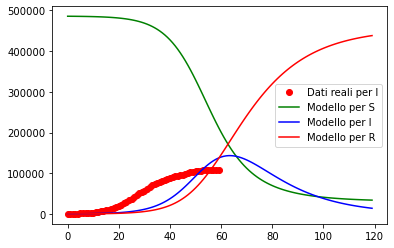

In [8]:
intervallo = np.arange(120)
y = SIR(N0, serie_I, serie_R, intervallo)
plt.plot(intervallo[:len(serie_I)], serie_I, 'ro', label="Dati reali per I")
plt.plot(intervallo, y[:,0], "g", label="Modello per S")
plt.plot(intervallo, y[:,1], "b", label="Modello per I")
plt.plot(intervallo, y[:,2], "r", label="Modello per R")
plt.legend()

The model suggests that the peak of infections will reach approximately 35 days after the first detection of our time series, and the infection will comprise roughly half of the population sample.

### Modified SIR model

The main problems of our model were due to the difficulty of estimating $N$, the size of the population. We can try to relativize the variables of our model, normalizing them with respect to $N$ and transforming them, in a certain sense, into percentages, simply by setting:
    $s = \frac SN, \quad i = \frac IN, \quad r = \frac RN$.
Our model is now without references to the size of the population and reads as:

$\begin{cases}
        s' = -\beta is  \\
        i' = \beta is -\gamma i \\
        r' = \gamma i
    \end{cases}$
   
We can use the same SIR function defined above and trying to normalize the series for $I$ and $R$:

In [9]:
N0 = np.mean(dfr2["tamponi"])
serie_I = np.array([dfr2["totale_positivi"]/N0])
II1 = serie_I[0]
II1 = (II1.tolist())

serie_R = np.array([(dfr2["dimessi_guariti"] + dfr2["deceduti"])/N0])
RR1 = serie_R[0]
RR1 = (RR1.tolist())

beta ottimale = 0.2012048645206061
gamma ottimale = 0.06812667931656305
R0 ottimale = 2.9533930985491157


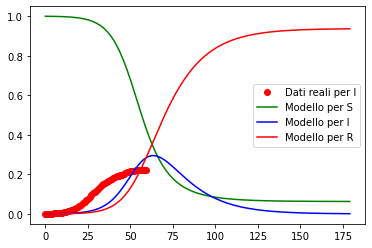

In [10]:
N0 = np.mean(dfr2["tamponi"])
serie_I = np.array(II1)
serie_R = np.array(RR1)

# Now plot the solution for the optimal values
intervallo = np.arange(180)
y = SIR(1, serie_I, serie_R, intervallo)
plt.plot(intervallo[:len(serie_I)], serie_I, 'ro', label="Dati reali per I")
plt.plot(intervallo, y[:,0], "g", label="Modello per S")
plt.plot(intervallo, y[:,1], "b", label="Modello per I")
plt.plot(intervallo, y[:,2], "r", label="Modello per R")
plt.legend()

From these graphs we can clearly see that the peak of infections is expected at about 35/40 days from the beginning of the data collection.

Qualitatively, the trend of the curves is that typical of the $SIR$ models for viral epidemics.

However, we can observe how the $R0$ (2.95) value obtained here is in line with the range of values also expressed in the literature in this period in relation to the development of the first phase of the pandemic period.
https://doi.org/10.1016/j.bsheal.2020.03.004.

### Data visualization

To get a clear idea of the pandemic trend in Italy, we now want to plot several graphs that allow us to visualize and better understand what is happening in this period.

##### New cases compared to previous days - Totals

Here we want to look at the number of cases that have occurred in the last 15 days

Text(0.5, 1.0, 'Nuovi casi rispetto ai giorni precedenti - Totali')

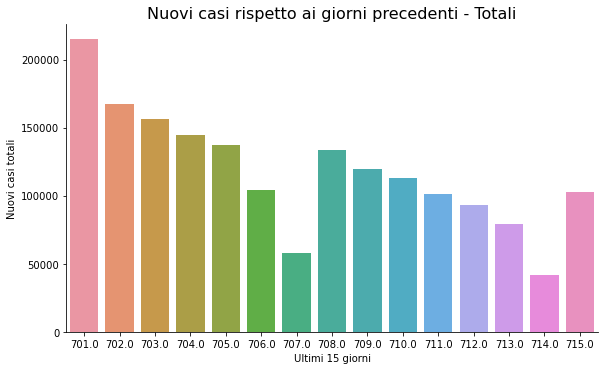

In [11]:
sns.catplot(kind='bar',data=dfr1.tail(15),y='NuoviCasi Totali',x='Days',aspect=1.7)
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d'))
plt.ylabel('Nuovi casi totali')
plt.xlabel('Ultimi 15 giorni')
plt.title('Nuovi casi rispetto ai giorni precedenti - Totali',fontsize=16)
#set_xticklabels(rotation=45)

We can observe how on Monday there is always a lower case number in relation to the fact that fewer swabs are carried out in the previous days

#### Plots showing changes over time

To observe the changes over time we use two functions through which we can see what happens during all the period of the measurements made.

1. *plot_measure*

2. *daily_measure*

In [12]:
# create the dataset Removed
dfr["Recovered"] = dfr["dimessi_guariti"].cumsum()
dfr["Fatalities"] = dfr["deceduti"].cumsum()
dfr["Removed"] = dfr["Recovered"] + dfr["Fatalities"]

In [13]:
def plot_measure(measure):
    x_labels = []
    dates = measure.index.tolist()

    i = 0
    step = 5
    while i < len(measure):
        x_labels.append(dates[i])
        i += step

    plt.figure(figsize=(25,10))
    plt.grid()

    plt.plot(measure)
    plt.xlim(dates[0],dates[len(dates)-1])

    plt.xticks(x_labels,rotation=90)
    plt.show()

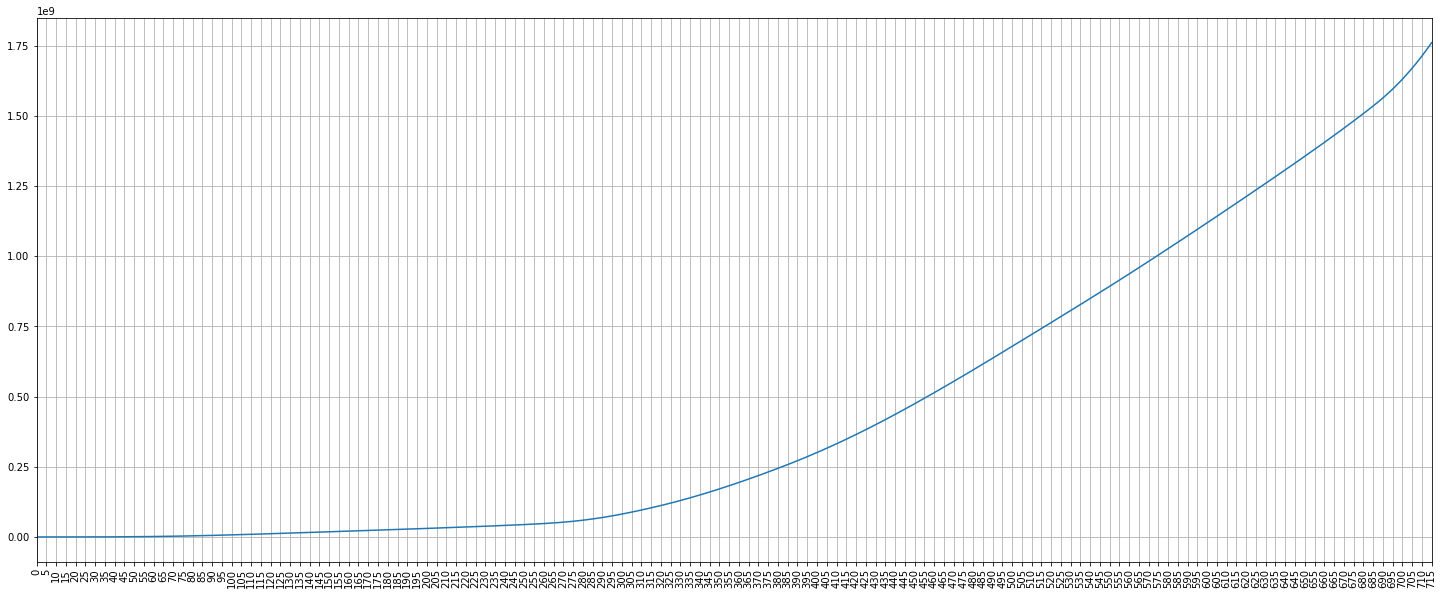

In [14]:
plot_measure(dfr["Removed"])

Here we can observe how there is an exponential increase in the curve for the Removed component

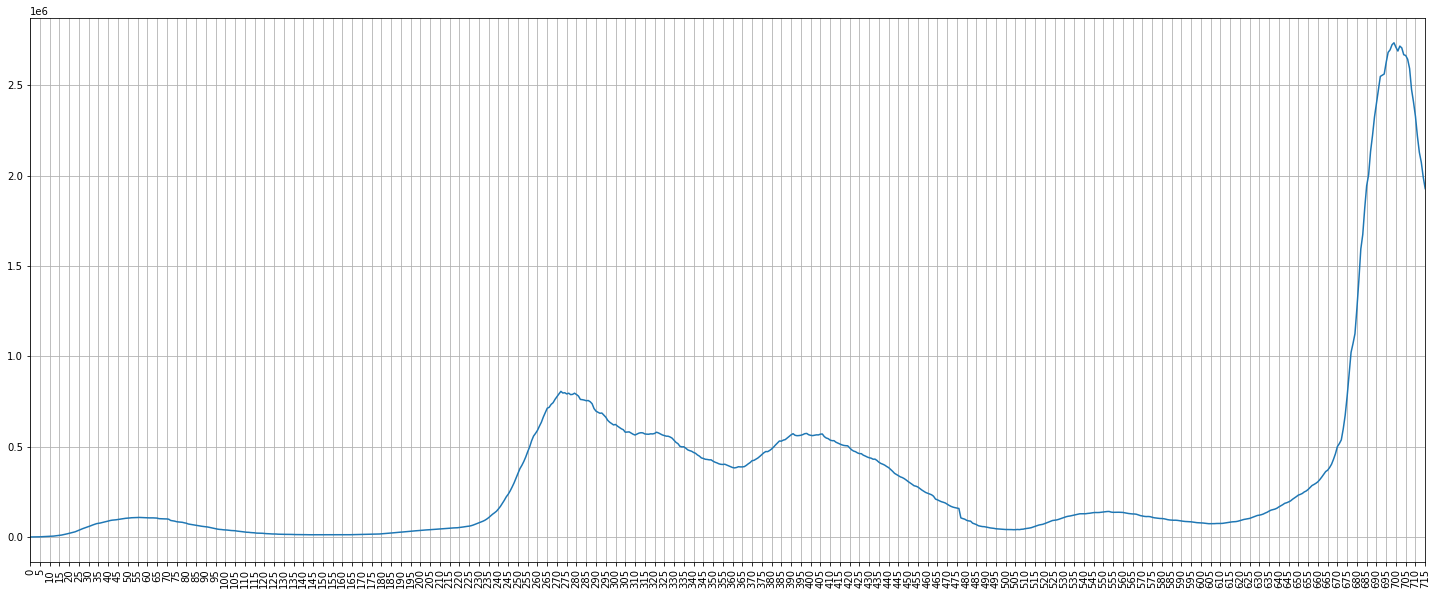

In [15]:
plot_measure(dfr['totale_positivi'])

In [16]:
def daily_measure(m):
    d_measure = []
    for i in range(1, len(m)):
        d_measure.append(m[i] - m[i-1])
    return pd.Series(d_measure, index=m.index[1:])

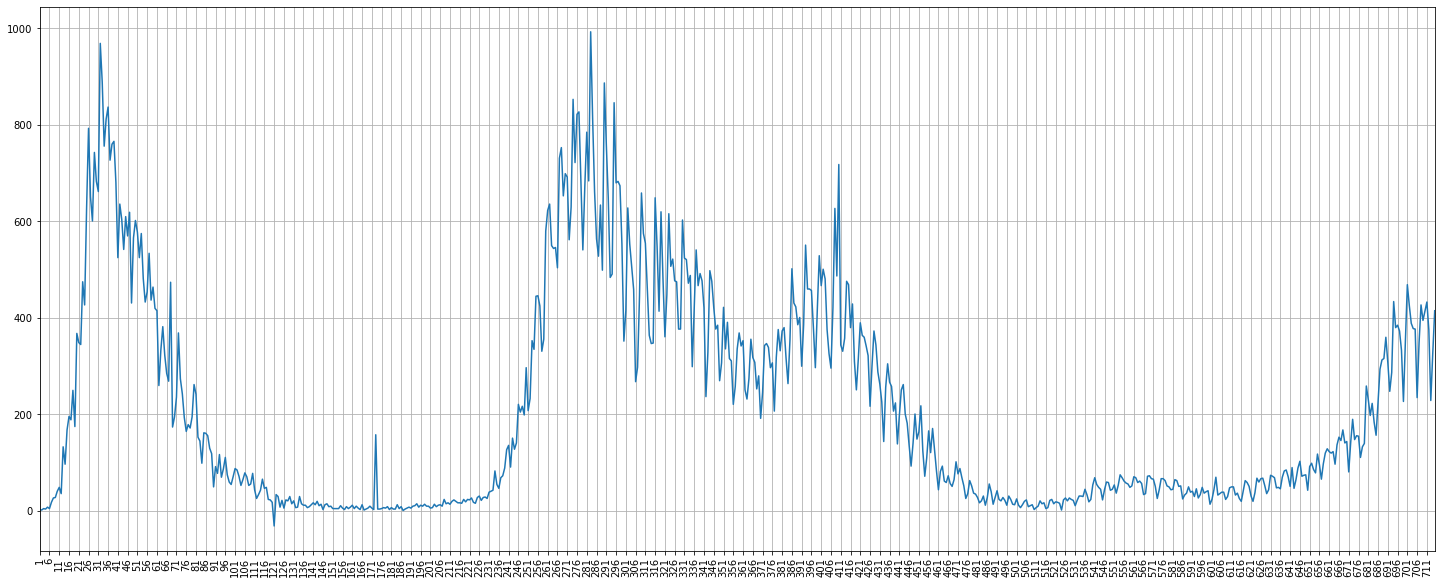

In [17]:
plot_measure(daily_measure(dfr['deceduti']))

Of course it is also possible to use other plots considering several other relevant parameters such as 'terapia_intensiva' and 'totale_ospedalizzati', as well as it is possible to improve the graphs above. The future goal could be to create an interactive plot based on the SIR model.

### Ipywidgets interactive plots

With Ipywidgets we can use an interactive approach that allows us to collect the user input and see the impact the changes have on the data / results, without having to interact with the code.In this particular case we can choose the day and see what is the situation of a specific Italian region associated with the same day.

In [18]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

##### Dataset used

For this part the github repository of the The Civil Protection Department: https://github.com/pcm-dpc/COVID-19/tree/master/dati-regioni  is used .

Initially, we will get the data and load it into a dataframe

In [19]:
url_R = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
region_data = pd.read_csv(url_R,error_bad_lines=False,parse_dates=['data'], index_col=['data'])
region_data.index = region_data.index.normalize()

C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
region_data.head(10)

,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,...,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
data,,,,,,,,,,,,,,,,,,,,,
2020-02-24,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,ITA,12,Lazio,41.892770,12.483667,1,1,2,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,ITA,7,Liguria,44.411493,8.932699,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,ITA,3,Lombardia,45.466794,9.190347,76,19,95,71,166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We prepare the dataset by filtering the dataset by *denominazione_regione*

In [21]:
region_data['Deaths'] = region_data.groupby(['denominazione_regione'])['deceduti'].transform(lambda x: x.diff())
region_data['Tamponi'] = region_data.groupby(['denominazione_regione'])['tamponi'].transform(lambda x: x.diff())
region_data['Recovered'] = region_data.groupby(['denominazione_regione'])['dimessi_guariti'].transform(lambda x: x.diff())

In [22]:
region_data1 = region_data[['totale_positivi','denominazione_regione','Tamponi','terapia_intensiva','dimessi_guariti','Deaths','Recovered','nuovi_positivi']]

We will create a generic function, *unique_sorted_values_plus_ALL*, which will find the unique values, sort them and then add the ALL item at the start, so the user could remove the filter

In [23]:
ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

We capture the cell output in a special kind of widget, namely Output, and then display it in another cell.

In [24]:
output = widgets.Output()

Here are the two dropdowns:

In [25]:
dropdown_region = widgets.Dropdown(options =unique_sorted_values_plus_ALL(region_data1.denominazione_regione),description='Region:')

dropdown_data = widgets.Dropdown(options = unique_sorted_values_plus_ALL(region_data1.index),description='Date:')

Then we create a new function, *common_filtering*, that will be called by both the event. This function will apply a filter on the dataframe for both region and data.

In [26]:
def common_filtering(region,data):
    output.clear_output()
    
    if (region == ALL) & (data == ALL):
        common_filter = region_data1
    elif (region == ALL):
        common_filter = region_data1[region_data1.index == data]
    elif (data == ALL):
        common_filter = region_data1[region_data1.denominazione_regione == region]
    else:
        common_filter = region_data1[(region_data1.denominazione_regione == region) & 
                                  (region_data1.index == data)]
    
    with output:
        display(common_filter)

We modify the event to call the *common_filtering* function and pass the *change.new* value as well as the current value of the other dropdown.

In [27]:
def dropdown_region_eventhandler(change):
    common_filtering(change.new, dropdown_data.value)
def dropdown_data_eventhandler(change):
    common_filtering(dropdown_region.value, change.new)

In [28]:
dropdown_region.observe(dropdown_region_eventhandler, names='value')
dropdown_data.observe(dropdown_data_eventhandler, names='value')

Finally we will stack the input widgets and the tab on top of each other with a *VBox*

In [29]:
input_widgets = widgets.VBox([dropdown_region, dropdown_data])
display(input_widgets)
display(output)

Output()